In [1]:
# import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder

import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2021-08-12 22:53:25,564 loading file C:\Users\Lenovo\.flair\models\sentiment-en-mix-distillbert_4.pt


# ------------------------------------Functions------------------------------------

### 1. Sentiment score

Use the pytorch flair (a sentimental analysis pakage) to determine how positive the text response is.  
<br>
1 is very positive and -1 is very negative

In [2]:
def sentiment_score(sentence):
    
    # sentimental analysis using flair
    s = flair.data.Sentence(sentence)
    flair_sentiment.predict(s)
    total_sentiment = s.labels
    
    
    # obtain the score from the prediction result
    ind = str(total_sentiment[0]).find(" ")
    num = float(str(total_sentiment[0])[ind+2:-1])

    # add a negative sign for regative predictions
    if "NEGATIVE" in str(total_sentiment[0]):
        num = 0 - num
        
    return num


###  2. Print the classification evaluation¶

In [3]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

def print_evaluate(classifier, y_test, prediction):  
    scores_accuracy = cross_val_score(classifier, x_df, y_df, cv=10, scoring='accuracy')
    scores_f1 = cross_val_score(classifier, x_df, y_df, cv=10, scoring='f1_macro')
    print('K-fold cross-validation results:')
    print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
    print(classifier.__class__.__name__+" average f1 is %2.3f" % scores_f1.mean())
    print('Classification report: ')
    print(classification_report(y_test, prediction))
    

### 3. Plot the ROC curve

In [4]:
from sklearn.metrics import roc_curve, auc
def plot_auc(y_test, prediction):
    [fpr, tpr, thr] = roc_curve(y_test, prediction)
    idx = np.min(np.where(tpr > 0.8))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()
    

# ---------------------------------------Data preprocessing---------------------------------------

##### 1. Read file

In [5]:
file_name = 'sample_dataset.csv'
df = pd.read_csv(file_name)
df.head()

,_id,MCQ_A10,MCQ_A11,MCQ_A13,MCQ_A14,MCQ_A15,MCQ_A18,MCQ_A2,MCQ_A20,MCQ_B7,...,MCQ_B85,MCQ_B89,MCQ_B90,MCQ_B91,MCQ_B95,MCQ_B98,job_family,gender,selected,text_response
0,5c76d8471367c00100f89d6b,4,2,1,2,4,3,2,4,5,...,3,2,3,5,3,3,Sales,female,1,'Shroud Shifter dude if I want to know the sec...
1,5bcfc7ad662dbc01002f3d0a,3,2,4,1,5,3,2,3,4,...,2,2,3,5,4,3,Retail,male,-1,'ESTP for Chloe is a very stereotyped typing. ...
2,5bdbc2b947d80d010012d488,4,1,1,1,4,4,2,2,5,...,1,2,3,4,2,3,CallCentre,male,-1,'become a stylist|||i trapped a giant house sp...
3,5c475f81e8a6aa01008f2cfb,4,1,2,1,5,2,1,3,4,...,2,2,4,5,4,4,Sales,male,-1,'Thank you for everyone's advice. I'll try to ...
4,5c75a5884c8e7a0100129667,5,5,1,4,5,3,1,4,4,...,4,2,3,5,5,3,Sales,male,-1,'http://www.youtube.com/watch?v=8UVNT4wvIGY|||...


###### As we can see, there are missing data (i.e., NaN), unavailable data (selected equals to -1), and machine unreadable data (text_response). 
- We need to remove the rows that contains NaN values. An alternative approach is to make reasonable assumption about the missing data (data imputation). However, the number of missing data in our case is a bit high so I choose to eliminate them.  
- Selected equals to -1 means the data is unavailable, therefore we need to eliminate or replace them. Here I choose to eliminate them.
- We need to translate the text to machine readable formats. Here I use a simple sentimental analysis to determine if the text positive or negative. A better way is to investigate in different aspects, such as confidence level, grammatical correctness, passion level, etc. 

##### 2. Count NaN values for each feature

In [6]:
df.isna().sum()

_id                0
MCQ_A10            0
MCQ_A11            0
MCQ_A13            0
MCQ_A14            0
MCQ_A15            0
MCQ_A18            0
MCQ_A2             0
MCQ_A20            0
MCQ_B7             0
MCQ_B76            0
MCQ_B78            0
MCQ_B79            0
MCQ_B8             0
MCQ_B82            0
MCQ_B85            0
MCQ_B89            0
MCQ_B90            0
MCQ_B91            0
MCQ_B95            0
MCQ_B98            0
job_family         0
gender           417
selected           0
text_response      0
dtype: int64

##### 3. Drop rows that contains NaN and drop "ID"

In [7]:
df.dropna(axis=0, inplace=True)
df.drop(['_id'], axis=1, inplace=True)

I0812 22:53:38.040764  1988 utils.py:157] NumExpr defaulting to 8 threads.


##### 4. Count how many instances that "selected" equals to 0, 1, -1 respectively.

In [8]:
select0 = df[df["selected"]==0].count()['selected']
select1 = df[df["selected"]==1].count()['selected']
select_minus1 = df[df["selected"]==-1].count()['selected']

In [9]:
evaluate_df = pd.DataFrame(data=[["Count", select0,select1,select_minus1]], 
                          columns=['Select', '0', '1', '-1'])
evaluate_df

,Select,0,1,-1
0,Count,749,582,1252


As we can see, a large portion of the data are unavailable. Therefore we choose to eliminate them.

##### 5. Remove the instances that "selected" equals to -1, because it indicates when the information is not available

In [10]:
df = df[df["selected"]!=-1]

##### 6. Apply sentimental analysis on the "text_response" column. The resulted values range from -1 to 1, where -1 is very negative and 1 is very positive.

In [11]:
df["text_response"] = df["text_response"].apply(sentiment_score)

# ---------------------------------------------Result---------------------------------------------

### 1. Preparation

##### 1.1. Label encoder

In [12]:
df[["job_family", "gender"]] = df[["job_family", "gender"]].apply(LabelEncoder().fit_transform)

##### 1.2 Prepare x, y labels for classification

In [13]:
x_df = df.drop('selected', axis = 1)
y_df = df['selected']

##### 1.3 Normalise the data

Note that this step is not essential for tree based classifiers.

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_df)
scaler.transform(x_df)

array([[7.5000e-01, 2.5000e-01, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 2.5000e-01, 2.5000e-01, ..., 1.0000e+00, 0.0000e+00,
        3.9350e-02],
       [7.5000e-01, 5.0000e-01, 2.5000e-01, ..., 5.0000e-01, 1.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 2.5000e-01, 0.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        9.9835e-01],
       [7.5000e-01, 2.5000e-01, 1.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        5.0000e-05],
       [5.0000e-01, 2.5000e-01, 0.0000e+00, ..., 5.0000e-01, 1.0000e+00,
        3.4450e-02]])

##### 1.4 Perform train test split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=15)

### 2. Perform classification and evaluate the result

##### 2.1. Create a gradient boost classifier

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)

gbc_prediction = gbc.predict(X_test)

##### Note: the performance can be improved by parameter tunning, but it would take too much time. A better approach is to use GridSearchCV to exhaustive search over specified parameter values for the estimator. The commented code is shown below.

In [17]:
"""
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


# Create the parameter grid based on the results of random search 
param_grid = {'n_estimators':[100, 200, 300,500], 
            'learning_rate': [0.1,0.05,0.02],
            'max_depth':[4], 
            'min_samples_leaf':[3], 
            'max_features':[1.0] } 
            
# Create a based model
gbc = GradientBoostingClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
                          
                          
# Fit the grid search to the data
grid_search.fit(X_train,y_train)
grid_search.best_params_

"""

"\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.ensemble import GradientBoostingClassifier\n\n\n# Create the parameter grid based on the results of random search \nparam_grid = {'n_estimators':[100, 200, 300,500], \n            'learning_rate': [0.1,0.05,0.02],\n            'max_depth':[4], \n            'min_samples_leaf':[3], \n            'max_features':[1.0] } \n            \n# Create a based model\ngbc = GradientBoostingClassifier()\n\n# Instantiate the grid search model\ngrid_search = GridSearchCV(estimator = gbc, param_grid = param_grid, \n                          cv = 3, n_jobs = -1, verbose = 2)\n                          \n                          \n# Fit the grid search to the data\ngrid_search.fit(X_train,y_train)\ngrid_search.best_params_\n\n"

##### 2.2 Print evaluation

In [18]:
print_evaluate(gbc, y_test, gbc_prediction)

K-fold cross-validation results:
GradientBoostingClassifier average accuracy is 0.598
GradientBoostingClassifier average f1 is 0.577
Classification report: 
              precision    recall  f1-score   support

           0       0.52      0.67      0.59       130
           1       0.57      0.42      0.48       137

    accuracy                           0.54       267
   macro avg       0.55      0.54      0.53       267
weighted avg       0.55      0.54      0.53       267



##### 2.3. Evaluate the importance of features

<AxesSubplot:>

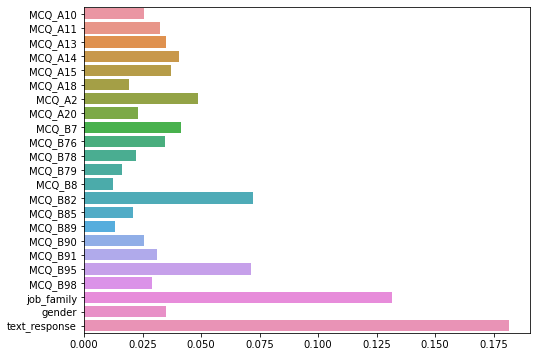

In [19]:
plt.figure(figsize=(8,6))
importance = gbc.feature_importances_
sns.barplot(x=importance, y=x_df.columns)

##### 2.4 Print the ROC curve

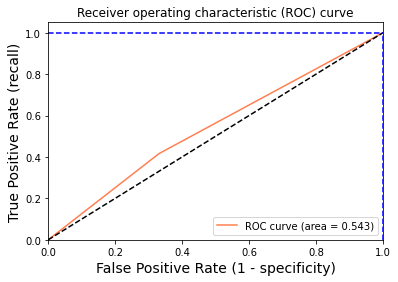

In [20]:
plot_auc(y_test, gbc_prediction)

##### 2.5 Print the partial dependency plots for every feature

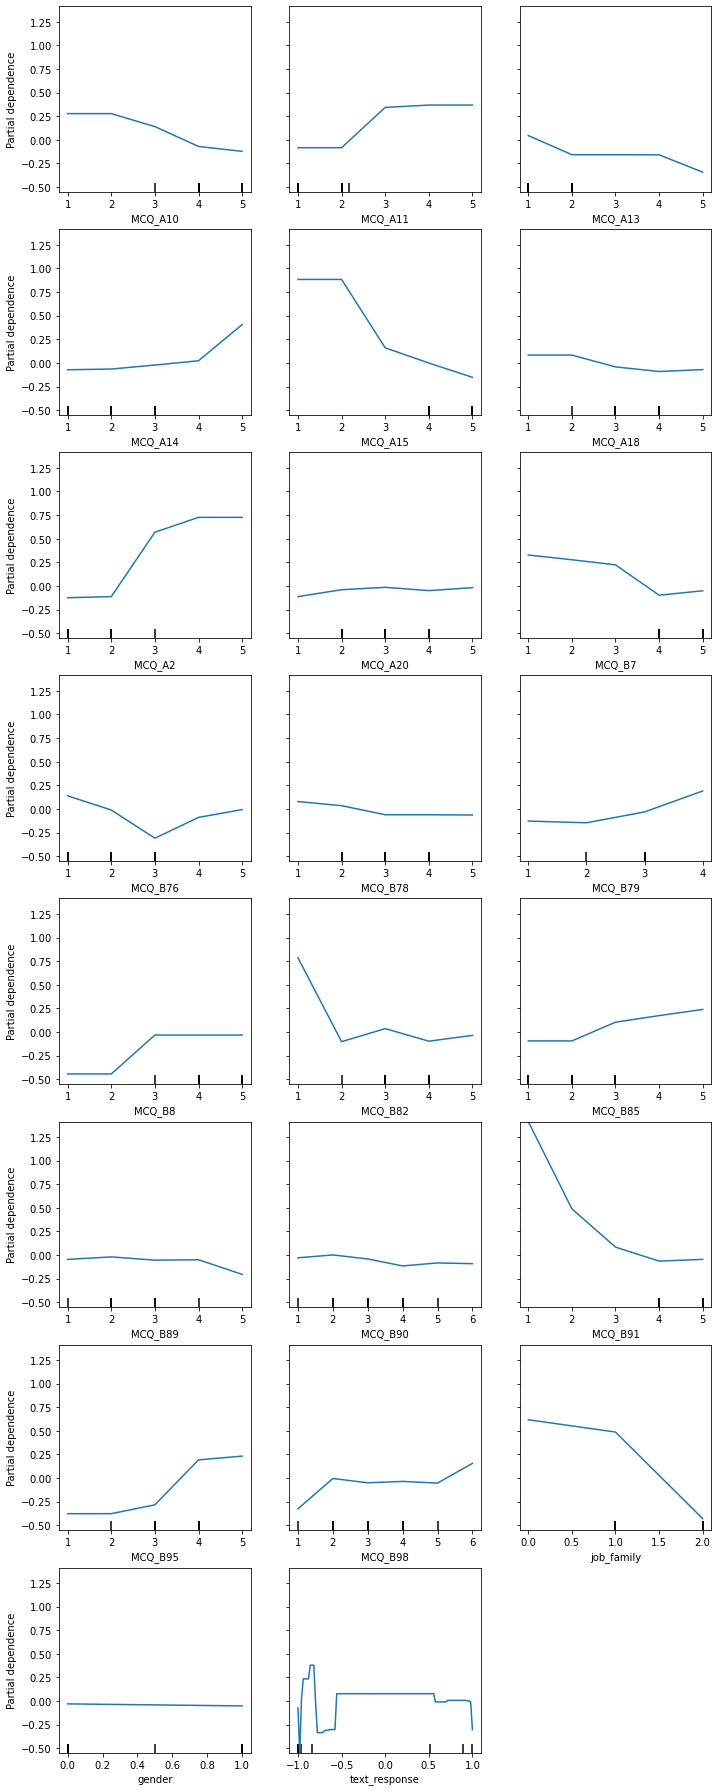

In [21]:
from sklearn.inspection import plot_partial_dependence
# features = ["gender", "text_response"]
features = [i for i in range(0,23)]

fig, ax = plt.subplots(figsize=(10, 25))
plot_partial_dependence(gbc, X_train, features, ax=ax) 
fig.tight_layout()


# ---------------------------------------Conclusion---------------------------------------

In this classification challenge, I choose the gradient boosting classifer to perform the binary classification problem. Alternative solutions include but not limited to logistic regression, KNN, SVM, and DNN. The reason I choose a tree based approach is because the dataset we are using has a large amount of features, and decision tree can clearly tell the importance of these features.  

##### 1. Performance

The gradient boosting classifier can achieve an average F1 score of 0.580. This can be improved by using parameter tunning, or using other models such as XGBOOST (it will take longer time so I choose Gradient boosting classifier).

##### 2. Fairness

The prediction result shows that it is treating male and female candidates relatively fair. This can be shown in two aspects:
- The feature importance diagram shows that "gender" has a lower importance compared to other features
- In the partial dependency plot of "gender", we can see that the difference between male and female is negligible

##### 3. Explainability

- The feature importance diagram shows that text_response and job_family are the two most important features to predict "selected"
- From the partial dependency plots, we can clearly see which value contributes more to the decision for each feature
- Our model is slightly more sensitive to negative texts compared to positive texts